# Stateful detection of black-box adversarial attack
Example for PyTorch library

## Setup

In [1]:
import numpy as np
import random 
np.random.seed(2137)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from scipy.ndimage import rotate

from art.estimators.encoding import PyTorchEncoder
from art.attacks.evasion import HopSkipJump, BoundaryAttack
from art.estimators.classification import PyTorchClassifier
from art.defences.detector.evasion.black_box import MemoryQueue, BlackBoxDetector, NearestNeighborsWrapper, torch_contrastive_loss
import matplotlib.pyplot as plt

## Get data

In [2]:
def get_dataset():
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_ds = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_ds = datasets.MNIST('./data', train=False, transform=transform)
    return train_ds, test_ds

In [3]:
train_ds, test_ds = get_dataset()

/Users/twardy/Code/studia/inzynierka/adversarial-robustness-toolbox/venv/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Get encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.drop = nn.Dropout(0.125)
        self.fc3 = nn.Linear(256, 64)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        x = self.fc3(x)
        return x
    
encoder_model = Encoder()
encoder_model.load_state_dict(torch.load("models/encoder.model"))
encoder_model.eval()

Encoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (drop): Dropout(p=0.125, inplace=False)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
)

## Prepare classifier

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.drop = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=-1)
        return x

classifier_model = Classifier()
classifier_model.load_state_dict(torch.load("models/classifier.model"))
classifier_model.eval()

Classifier(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [15]:
classifier = PyTorchClassifier(
    model=classifier_model,
    loss=torch.nn.functional.nll_loss,
    input_shape=(1, 28, 28),
    nb_classes=10
)

Classifier simple validation:

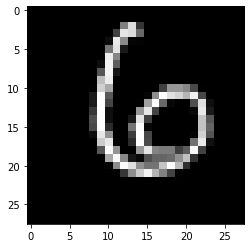

In [16]:
example = test_ds.data[100].numpy()
example = example.reshape(-1, 28, 28)
plt.imshow(example[0], cmap="gray")

In [17]:
np.argmax(classifier.predict(example))

6

## Detection

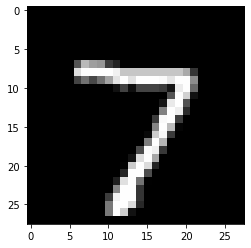

In [18]:
target = test_ds.data[0].numpy()
target = target.reshape(-1, 28, 28)
plt.imshow(target[0], cmap="gray")

In [19]:
encoder = PyTorchEncoder(model=encoder_model, input_shape=(1, 28, 28), encoding_length=64)

In [20]:
k = 20
threshold = 0.003
max_size = 100
MAX_QUERIES = 1000

### HopSkipJump attack

In [21]:
attack = HopSkipJump(
    classifier=classifier,
    targeted=False,
    max_iter=0,
    max_eval=1,
    init_eval=1
)

In [22]:
queue = MemoryQueue(max_size=max_size, element_shape=(64,))
knn = NearestNeighborsWrapper(k_neighbors=k, memory_queue=queue)
detector = BlackBoxDetector(
    similarity_encoder=encoder,
    memory_queue=queue,
    knn=knn,
    detection_threshold=threshold
)

In [27]:
x_adv = None
for i in range(MAX_QUERIES):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv, resume=True)
    encoded_adv = encoder.predict(x_adv)
    queue.extend(encoded_adv)
    knn.update_memory()
    # Wait until queue has minimum of "K" neighbours length
    if i < k:
        continue
    # Here we are scaning the query
    is_detected, distance = detector.scan(x_adv)
    # Here we add new query to queue
    encoded_adv = encoder.predict(x_adv)
    queue.extend(encoded_adv)
    knn.update_memory()
    
    print(f"L2 error {np.linalg.norm(x_adv[0] - target)}, predicted class {np.argmax(classifier.predict(x_adv))}")
    print(f"Is attack detected: {is_detected}, adv example mean k-distance: {distance}")
    if is_detected:
        print("-" * 100)
        print(f"Attack detected at iteration {i}!")
        break

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 705.8544311523438, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.004042686428874731


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 694.8079833984375, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.004722310695797205


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 684.5, predicted class 3
Is attack detected: True, adv example mean k-distance: 0.002908478258177638
----------------------------------------------------------------------------------------------------
Attack detected at iteration 22!


### Boundary attack

In [28]:
attack = BoundaryAttack(
    estimator=classifier,
    targeted=False,
    max_iter=1,
    delta=0.5,
    epsilon=0.1
)

In [29]:
queue = MemoryQueue(max_size=max_size, element_shape=(64,))
knn = NearestNeighborsWrapper(k_neighbors=k, memory_queue=queue)
detector = BlackBoxDetector(
    similarity_encoder=encoder,
    memory_queue=queue,
    knn=knn,
    detection_threshold=threshold
)

In [30]:
x_adv = None
for i in range(MAX_QUERIES):
    x_adv = attack.generate(x=np.array([target]), x_adv_init=x_adv, resume=True)
    encoded_adv = encoder.predict(x_adv)
    queue.extend(encoded_adv)
    knn.update_memory()
    # Wait until queue has minimum of "K" neighbours length
    if i < k:
        continue
    # Here we are scaning the query
    is_detected, distance = detector.scan(x_adv)
    # Here we add new query to queue
    encoded_adv = encoder.predict(x_adv)
    queue.extend(encoded_adv)
    knn.update_memory()
    
    print(f"L2 error {np.linalg.norm(x_adv[0] - target)}, predicted class {np.argmax(classifier.predict(x_adv))}")
    print(f"Is attack detected: {is_detected}, adv example mean k-distance: {distance}")
    if is_detected:
        print("-" * 100)
        print(f"Attack detected at iteration {i}!")
        break

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 623.2171630859375, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.0731213241815567


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 613.63330078125, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.045636869966983795


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 599.9093017578125, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.028439398854970932


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 588.8134765625, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.019358420744538307


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 585.4185791015625, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.012997595593333244


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 582.775634765625, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.008595745079219341


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 578.376220703125, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.00866662710905075


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 576.7111206054688, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.007158994674682617


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 574.8346557617188, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.005695591680705547


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 566.687255859375, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.0044965255074203014


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 562.029052734375, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.004802496172487736


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 560.3779907226562, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.0040712603367865086


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 559.7966918945312, predicted class 3
Is attack detected: False, adv example mean k-distance: 0.003235423471778631


Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1 [00:00<?, ?it/s]

L2 error 559.3011474609375, predicted class 3
Is attack detected: True, adv example mean k-distance: 0.00237139780074358
----------------------------------------------------------------------------------------------------
Attack detected at iteration 33!
